In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from pyod.models.knn import KNN 

from sklearn.feature_selection import( 
    RFECV,
    SequentialFeatureSelector,
    SelectFromModel
)

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import(
    RandomForestClassifier,
    HistGradientBoostingClassifier
)

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from src.wrapped import Wrapped
from src.analyses import  graphic_anomalies
from src.train import cross_validate_balancead, train_feature_combination

In [3]:
wp = Wrapped(
    '../data/row/',
    '../data/processed/',
    '../data/files/'
)

# Importando dados para treinamento

In [4]:
df = wp.load_data('df_instrumentos_features_selecionadas')

In [5]:
# instrumentos de corda:
inst_corda = ["cello", "guitar", "violin", "bass", "banjo", "mandolin", "ukulele"]

df = df[df['instrumento'].isin(inst_corda)]

- Definindo as variaveis de treino e o target

In [6]:
le = LabelEncoder()
df['labels'] = le.fit_transform(df.instrumento)

In [7]:
X = df.drop(columns=['labels', 'instrumento','file_name'])
y = df['labels'].to_frame()

# TESTE 1: Balanceamento

- 1° Opção: Balanceamento das classes com SMOTH

In [ ]:
t1_models = np.array([
    GaussianNB(),
    KNeighborsClassifier(), 
    DecisionTreeClassifier(), 
    RandomForestClassifier(), 
    HistGradientBoostingClassifier(),
    LGBMClassifier(),
    MLPClassifier(),
    SVC(),
])

t1_acuracy_models = [cross_validate_balancead(k=5, model=model, X=X, y=y, oversampling=True) for model in t1_models]

dict_results_t1 = {
    'Naive Bayes': t1_acuracy_models[0],
    'KNN': t1_acuracy_models[1],
    'Arvore de Decisão': t1_acuracy_models[2],
    'Floresta Aleatoria': t1_acuracy_models[3],
    'HistGradientBoosting': t1_acuracy_models[4],
    'LIGHTGBM': t1_acuracy_models[5],
    'MLP': t1_acuracy_models[6],
    'SVC': t1_acuracy_models[7],
}

dict_results_t1

- 2° Opção: Class Weight

In [ ]:
models_class_weight = np.array([
    DecisionTreeClassifier(class_weight='balanced'), 
    RandomForestClassifier(class_weight='balanced', random_state = 0, n_jobs = -1), 
    LGBMClassifier(class_weight='balanced'),
])

t1_acuracy_models_class_weight = [cross_validate_balancead(k=5, model=model, X=X, y=y, weight=True) for model in models_class_weight]

dict_results_t1_class_weight = {
    'Arvore de Decisão': t1_acuracy_models_class_weight[0],
    'Floresta Aleatoria': t1_acuracy_models_class_weight[1],
    'LIGHTGBM': t1_acuracy_models_class_weight[2],
}

dict_results_t1_class_weight

Acuracia do modelo DecisionTreeClassifier(class_weight='balanced') do Fold 0: 0.3546617915904936
Acuracia do modelo DecisionTreeClassifier(class_weight='balanced') do Fold 1: 0.340036563071298
Acuracia do modelo DecisionTreeClassifier(class_weight='balanced') do Fold 2: 0.36446886446886445
Acuracia do modelo DecisionTreeClassifier(class_weight='balanced') do Fold 3: 0.358974358974359
Acuracia do modelo DecisionTreeClassifier(class_weight='balanced') do Fold 4: 0.358974358974359
Acuracia do modelo RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=0) do Fold 0: 0.5283363802559415
Acuracia do modelo RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=0) do Fold 1: 0.4990859232175503
Acuracia do modelo RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=0) do Fold 2: 0.5347985347985348
Acuracia do modelo RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=0) do Fold 3: 0.5128205128205128
Acuracia do modelo Ra

{'Arvore de Decisão': 0.3554231874158748,
 'Floresta Aleatoria': 0.5219679771782147,
 'LIGHTGBM': 0.538808418881545}

# TESTE 2: Remover Outlier

- Treinar modelo de classificação de outilier

In [8]:
detector_outilier = KNN()

new_df = df.drop(columns=['instrumento','file_name'])

detector_outilier.fit(new_df)

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

- Checar numeros de outilers e não outilers<br/>
**0 (False) Não é outiler**<br/>
**1 (True) É outiler**

In [9]:
previsions = detector_outilier.labels_
np.unique(previsions, return_counts=True)

(array([0, 1]), array([2458,  274]))

- Distancia euclidiana dos registros

In [10]:
confiance_previsions = detector_outilier.decision_scores_
confiance_previsions

array([ 420.42515301,  373.65251402,  472.76119518, ...,  356.52528336,
       2043.19364258,  387.526779  ])

- Checar os outilers

In [11]:
# pegando indice dos registros que são outilers
outilers_id =[previsions[i] == 1 for i in range(previsions.shape[0])]
outilers = df.iloc[outilers_id,:]
outilers

tonnetz0  tonnetz1   chroma1   chroma2   chroma3   chroma4   chroma5  \
524   0.044009  0.049910  0.422762  0.372759  0.418751  0.342388  0.345684   
546  -0.019221  0.017872  0.412917  0.454047  0.530891  0.557669  0.349409   
548   0.104703 -0.251793  0.163021  0.812954  0.344378  0.115020  0.292584   
555  -0.035994  0.023556  0.502060  0.572897  0.544631  0.463271  0.181727   
570   0.128059  0.082795  0.264848  0.264230  0.504677  0.353699  0.363608   
...        ...       ...       ...       ...       ...       ...       ...   
7999  0.188614 -0.123051  0.435805  0.078954  0.048469  0.095815  0.166382   
8016  0.066705 -0.239727  0.177657  0.249958  0.202065  0.227559  0.358576   
8017  0.096697 -0.279816  0.159033  0.078111  0.079078  0.180735  0.292732   
8020  0.015595 -0.058762  0.120028  0.238263  0.234643  0.267743  0.228591   
8022  0.004588 -0.009204  0.124913  0.174113  0.185558  0.169614  0.149416   

       chroma6   chroma7       mfcc0  ...  spectral_centroid  spectral_onset  \
524   0.425205  0.419690 -113.403656  ...        2589.236162        1.418300   
546   0.344261  0.382070 -202.772339  ...        3004.965818        1.600475   
548   0.153532  0.169621 -140.371948  ...        1704.019101        1.065461   
555   0.342575  0.116119 -176.971466  ...        2065.352164        1.527929   
570   0.434325  0.461813  -43.627769  ...        3178.869223        1.445494   
...        ...       ...         ...  ...                ...             ...   
7999  0.088318  0.250419 -390.158630  ...        1772.864514        1.268380   
8016  0.191313  0.535777 -163.197540  ...        2049.088272        1.239214   
8017  0.125269  0.363708 -115.140617  ...        2277.244488        1.186836   
8020  0.260930  0.267262 -324.705627  ...        3573.542978        1.354204   
8022  0.075544  0.081894 -414.280731  ...        3720.081212        1.332893   

      spectral_rolloff  spectogram  mel_spectogram  zero_crossing_rate  \
524        5736.500270  -55.941154      -70.428162            0.124409   
546        5830.002334  -78.944046      -80.000000            0.175861   
548        2712.683983  -69.137093      -79.591011            0.129967   
555        3548.731828  -65.745941      -79.547966            0.154887   
570        6845.210425  -47.192692      -59.145737            0.158472   
...                ...         ...             ...                 ...   
7999       2945.977004  -76.595161      -80.000000            0.126178   
8016       3472.241494  -45.379463      -80.000000            0.128462   
8017       3779.127109  -50.537724      -80.000000            0.143759   
8020       6552.813508  -43.596504      -73.498703            0.230540   
8022       6207.732687  -37.720039      -72.552101            0.241853   

      zero_crossing  instrumento          file_name  labels  
524           27503        banjo   004313_23040.ogg       0  
546           38878        banjo  010368_199680.ogg       0  
548           28745        banjo   010444_30720.ogg       0  
555           34292        banjo  012743_192000.ogg       0  
570           35001        banjo   014956_57600.ogg       0  
...             ...          ...                ...     ...  
7999          27872       violin       147132_0.ogg       6  
8016          28414       violin  151275_138240.ogg       6  
8017          31806       violin   151281_61440.ogg       6  
8020          50962       violin  154469_318720.ogg       6  
8022          53491       violin   154881_76800.ogg       6  

[274 rows x 47 columns]

In [12]:
outilers.instrumento.value_counts()

violin      85
bass        55
banjo       35
guitar      35
ukulele     29
mandolin    24
cello       11
Name: instrumento, dtype: int64

- Grafico 

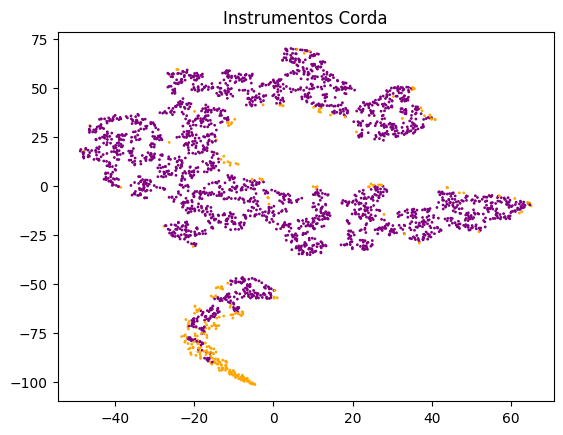

In [13]:
graphic_anomalies(df.drop(columns=['instrumento','file_name']), 'Instrumentos Corda')

- Agora vamos remover os outilers da nossa base

In [ ]:
# pegando indice dos registros que não são outilers
outilers_id =[previsions[i] == 0 for i in range(previsions.shape[0])]
df_train = df.iloc[outilers_id,:]
df_train

tonnetz0  tonnetz1   chroma1   chroma2   chroma3   chroma4   chroma5  \
511  -0.126759 -0.059743  0.413241  0.216319  0.150052  0.123013  0.273308   
512  -0.031109 -0.064497  0.226724  0.379728  0.534193  0.384524  0.330155   
513   0.009446  0.006492  0.469337  0.108270  0.112574  0.109360  0.286641   
514   0.037982 -0.073602  0.340242  0.296036  0.302441  0.279111  0.539927   
515   0.062163 -0.025827  0.641626  0.313273  0.320937  0.305392  0.414052   
...        ...       ...       ...       ...       ...       ...       ...   
8015  0.155398  0.202623  0.279203  0.175173  0.329897  0.101118  0.119236   
8018  0.181463 -0.109062  0.259089  0.054198  0.135665  0.120070  0.198278   
8019  0.051950  0.691044  0.773323  0.582712  0.532384  0.274606  0.127275   
8021  0.093624 -0.031124  0.253249  0.321181  0.309254  0.265595  0.265015   
8023  0.158450  0.087372  0.537541  0.238255  0.197415  0.234096  0.413693   

       chroma6   chroma7       mfcc0  ...  spectral_centroid  spectral_onset  \
511   0.355497  0.252558 -181.227707  ...        1463.383714        1.480360   
512   0.257401  0.416313  -92.888756  ...        1895.418478        1.607456   
513   0.663893  0.309304 -113.852753  ...        1627.584519        1.189757   
514   0.324625  0.385215 -175.193634  ...        2266.128437        1.524973   
515   0.317208  0.248327  -72.022423  ...        1838.567834        1.174259   
...        ...       ...         ...  ...                ...             ...   
8015  0.150895  0.161468 -106.568298  ...        2266.961445        1.172216   
8018  0.268761  0.094458 -233.943954  ...        1356.828177        0.969832   
8019  0.109617  0.158079 -260.673492  ...         658.017342        1.227272   
8021  0.155659  0.181344 -128.199768  ...        1421.358194        1.173742   
8023  0.344178  0.151779  -94.144447  ...        1946.691119        1.060153   

      spectral_rolloff  spectogram  mel_spectogram  zero_crossing_rate  \
511        2798.641932  -55.223148      -79.620255            0.084137   
512        3952.566819  -42.981918      -79.185867            0.083941   
513        2740.437335  -61.928226      -80.000000            0.084799   
514        4315.358824  -29.665657      -71.880913            0.120456   
515        3889.366118  -61.702564      -79.314026            0.087291   
...                ...         ...             ...                 ...   
8015       4213.738093  -42.284138      -79.955719            0.133785   
8018       2408.271439  -62.397167      -78.355164            0.083315   
8019       1367.932950  -35.302883      -68.164001            0.019043   
8021       2751.578644  -48.512993      -66.277359            0.065123   
8023       4276.888833  -54.351154      -66.739700            0.097089   

      zero_crossing  instrumento          file_name  labels  
511           18597        banjo  000202_142080.ogg       0  
512           18554        banjo   000606_15360.ogg       0  
513           18757        banjo  000725_445440.ogg       0  
514           26623        banjo   001490_23040.ogg       0  
515           19287        banjo   001691_15360.ogg       0  
...             ...          ...                ...     ...  
8015          29606       violin   151094_42240.ogg       6  
8018          18430       violin   151790_99840.ogg       6  
8019           4212       violin   152864_26880.ogg       6  
8021          14407       violin   154677_26880.ogg       6  
8023          21458       violin   155127_84480.ogg       6  

[2458 rows x 47 columns]

- Treinar modelos sem outlier e balanceameto

In [ ]:
X_rm_outilers = df_train.drop(columns=['labels', 'instrumento','file_name'])
y_rm_outilers = df_train['labels'].to_frame()

models = np.array([
    GaussianNB(),
    KNeighborsClassifier(), 
    DecisionTreeClassifier(), 
    RandomForestClassifier(), 
    HistGradientBoostingClassifier(),
    LGBMClassifier(),
    MLPClassifier(),
    SVC(),
])

t2_acuracy_models = [cross_validate_balancead(k=5, model=model, X=X_rm_outilers,  y=y_rm_outilers) for model in models]

dict_results_t2 = {
    'Naive Bayes': t2_acuracy_models[0],
    'KNN': t2_acuracy_models[1],
    'Arvore de Decisão': t2_acuracy_models[2],
    'Floresta Aleatoria': t2_acuracy_models[3],
    'HistGradientBoosting': t2_acuracy_models[4],
    'LIGHTGBM': t2_acuracy_models[5],
    'MLP': t2_acuracy_models[6],
    'SVC': t2_acuracy_models[7],
}

dict_results_t2

Acuracia do modelo GaussianNB() do Fold 0: 0.4105691056910569
Acuracia do modelo GaussianNB() do Fold 1: 0.39227642276422764
Acuracia do modelo GaussianNB() do Fold 2: 0.4715447154471545
Acuracia do modelo GaussianNB() do Fold 3: 0.4623217922606925
Acuracia do modelo GaussianNB() do Fold 4: 0.45213849287169044
Acuracia do modelo KNeighborsClassifier() do Fold 0: 0.2926829268292683
Acuracia do modelo KNeighborsClassifier() do Fold 1: 0.2784552845528455
Acuracia do modelo KNeighborsClassifier() do Fold 2: 0.3130081300813008
Acuracia do modelo KNeighborsClassifier() do Fold 3: 0.3014256619144603
Acuracia do modelo KNeighborsClassifier() do Fold 4: 0.3095723014256619
Acuracia do modelo DecisionTreeClassifier() do Fold 0: 0.33739837398373984
Acuracia do modelo DecisionTreeClassifier() do Fold 1: 0.34959349593495936
Acuracia do modelo DecisionTreeClassifier() do Fold 2: 0.3800813008130081
Acuracia do modelo DecisionTreeClassifier() do Fold 3: 0.35234215885947046
Acuracia do modelo DecisionTr

{'Naive Bayes': 0.43777010580696435,
 'KNN': 0.29902886096070735,
 'Arvore de Decisão': 0.3498708459589688,
 'Floresta Aleatoria': 0.5191197655357408,
 'HistGradientBoosting': 0.5329566340469921,
 'LIGHTGBM': 0.5402737072177238,
 'MLP': 0.30267746261984,
 'SVC': 0.3592295464706175}

# TESTE 3: Features de Maior Correlação

In [ ]:
df_corr = df.drop(columns=['instrumento', 'file_name', 'labels']).corr().unstack().reset_index().dropna()
df_corr.rename(columns = {'level_0': 'features_a', 'level_1': 'features_b', 0:'correlacao'}, inplace = True)
df_corr

features_a          features_b  correlacao
0          tonnetz0            tonnetz0    1.000000
1          tonnetz0            tonnetz1    0.022123
2          tonnetz0             chroma1   -0.159354
3          tonnetz0             chroma2   -0.167101
4          tonnetz0             chroma3    0.171987
...             ...                 ...         ...
1931  zero_crossing    spectral_rolloff    0.778658
1932  zero_crossing          spectogram   -0.108128
1933  zero_crossing      mel_spectogram   -0.144471
1934  zero_crossing  zero_crossing_rate    0.999998
1935  zero_crossing       zero_crossing    1.000000

[1936 rows x 3 columns]

- Correlação Positia

In [ ]:
corr_posit = df_corr.query('correlacao > 0.5 and correlacao < 1.0')
corr_posit

features_a          features_b  correlacao
181              chroma3             chroma4    0.501827
224              chroma4             chroma3    0.501827
271              chroma5             chroma6    0.583305
314              chroma6             chroma5    0.583305
587                mfcc4               mfcc6    0.516223
...                  ...                 ...         ...
1891  zero_crossing_rate       zero_crossing    0.999998
1926       zero_crossing      spectral_band2    0.542811
1929       zero_crossing   spectral_centroid    0.879911
1931       zero_crossing    spectral_rolloff    0.778658
1934       zero_crossing  zero_crossing_rate    0.999998

[68 rows x 3 columns]

In [ ]:
corr_posit.features_a.unique()

array(['chroma3', 'chroma4', 'chroma5', 'chroma6', 'mfcc4', 'mfcc5',
       'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12',
       'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'spectral_band2',
       'spectral_band3', 'spectral_band4', 'spectral_centroid',
       'spectral_rolloff', 'spectogram', 'mel_spectogram',
       'zero_crossing_rate', 'zero_crossing'], dtype=object)

In [ ]:
X =  df[corr_posit.features_a.unique()]
y = df['labels'].to_frame()

models = np.array([
    GaussianNB(),
    KNeighborsClassifier(), 
    DecisionTreeClassifier(), 
    RandomForestClassifier(), 
    HistGradientBoostingClassifier(),
    LGBMClassifier(),
    MLPClassifier(),
    SVC(),
])

t3_acuracy_models_corr_posit = [cross_validate_balancead(k=5, model=model, X=X, y=y) for model in models]

dict_results_t3_corr_posit = {
    'Naive Bayes': t3_acuracy_models_corr_posit[0],
    'KNN': t3_acuracy_models_corr_posit[1],
    'Arvore de Decisão': t3_acuracy_models_corr_posit[2],
    'Floresta Aleatoria': t3_acuracy_models_corr_posit[3],
    'HistGradientBoosting': t3_acuracy_models_corr_posit[4],
    'LIGHTGBM': t3_acuracy_models_corr_posit[5],
    'MLP': t3_acuracy_models_corr_posit[6],
    'SVC': t3_acuracy_models_corr_posit[7],
}

dict_results_t3_corr_posit

Acuracia do modelo GaussianNB() do Fold 0: 0.39488117001828155
Acuracia do modelo GaussianNB() do Fold 1: 0.3619744058500914
Acuracia do modelo GaussianNB() do Fold 2: 0.4194139194139194
Acuracia do modelo GaussianNB() do Fold 3: 0.43772893772893773
Acuracia do modelo GaussianNB() do Fold 4: 0.3772893772893773
Acuracia do modelo KNeighborsClassifier() do Fold 0: 0.3016453382084095
Acuracia do modelo KNeighborsClassifier() do Fold 1: 0.283363802559415
Acuracia do modelo KNeighborsClassifier() do Fold 2: 0.3131868131868132
Acuracia do modelo KNeighborsClassifier() do Fold 3: 0.31135531135531136
Acuracia do modelo KNeighborsClassifier() do Fold 4: 0.29853479853479853
Acuracia do modelo DecisionTreeClassifier() do Fold 0: 0.2906764168190128
Acuracia do modelo DecisionTreeClassifier() do Fold 1: 0.3071297989031079
Acuracia do modelo DecisionTreeClassifier() do Fold 2: 0.2967032967032967
Acuracia do modelo DecisionTreeClassifier() do Fold 3: 0.2967032967032967
Acuracia do modelo DecisionTree

{'Naive Bayes': 0.3982575620601215,
 'KNN': 0.3016172127689495,
 'Arvore de Decisão': 0.2983158218990029,
 'Floresta Aleatoria': 0.47073146232195595,
 'HistGradientBoosting': 0.47184308683394605,
 'LIGHTGBM': 0.46560794476699413,
 'MLP': 0.2811271604690252,
 'SVC': 0.3605406780909523}

- Correlação Negativa

In [ ]:
corr_negat = df_corr.query('correlacao > -1.0 and correlacao < -0.5')
corr_negat

features_a          features_b  correlacao
474                mfcc1      spectral_band2   -0.824213
475                mfcc1      spectral_band3   -0.764968
476                mfcc1      spectral_band4   -0.682582
477                mfcc1   spectral_centroid   -0.845359
479                mfcc1    spectral_rolloff   -0.827660
482                mfcc1  zero_crossing_rate   -0.666717
483                mfcc1       zero_crossing   -0.666821
1506      spectral_band2               mfcc1   -0.824213
1550      spectral_band3               mfcc1   -0.764968
1594      spectral_band4               mfcc1   -0.682582
1638   spectral_centroid               mfcc1   -0.845359
1726    spectral_rolloff               mfcc1   -0.827660
1858  zero_crossing_rate               mfcc1   -0.666717
1902       zero_crossing               mfcc1   -0.666821

In [ ]:
X =  df[corr_negat.features_b.unique()]
y = df['labels'].to_frame()

models = np.array([
    GaussianNB(),
    KNeighborsClassifier(), 
    DecisionTreeClassifier(), 
    RandomForestClassifier(), 
    HistGradientBoostingClassifier(),
    LGBMClassifier(),
    XGBClassifier(),
    MLPClassifier(),
    SVC(),
])

t3_acuracy_models_corr_neg = [cross_validate_balancead(k=5, model=model, X=X, y=y) for model in models]

dict_results_t3_corr_neg = {
    'Naive Bayes': t3_acuracy_models_corr_neg[0],
    'KNN': t3_acuracy_models_corr_neg[1],
    'Arvore de Decisão': t3_acuracy_models_corr_neg[2],
    'Floresta Aleatoria': t3_acuracy_models_corr_neg[3],
    'HistGradientBoosting': t3_acuracy_models_corr_neg[4],
    'LIGHTGBM': t3_acuracy_models_corr_neg[5],
    'MLP': t3_acuracy_models_corr_neg[6],
    'SVC': t3_acuracy_models_corr_neg[7],
}

dict_results_t3_corr_neg

Acuracia do modelo GaussianNB() do Fold 0: 0.31078610603290674
Acuracia do modelo GaussianNB() do Fold 1: 0.28884826325411334
Acuracia do modelo GaussianNB() do Fold 2: 0.33882783882783885
Acuracia do modelo GaussianNB() do Fold 3: 0.326007326007326
Acuracia do modelo GaussianNB() do Fold 4: 0.2802197802197802
Acuracia do modelo KNeighborsClassifier() do Fold 0: 0.2979890310786106
Acuracia do modelo KNeighborsClassifier() do Fold 1: 0.2870201096892139
Acuracia do modelo KNeighborsClassifier() do Fold 2: 0.315018315018315
Acuracia do modelo KNeighborsClassifier() do Fold 3: 0.31135531135531136
Acuracia do modelo KNeighborsClassifier() do Fold 4: 0.30036630036630035
Acuracia do modelo DecisionTreeClassifier() do Fold 0: 0.30347349177330896
Acuracia do modelo DecisionTreeClassifier() do Fold 1: 0.29981718464351004
Acuracia do modelo DecisionTreeClassifier() do Fold 2: 0.2802197802197802
Acuracia do modelo DecisionTreeClassifier() do Fold 3: 0.29304029304029305
Acuracia do modelo DecisionT

{'Naive Bayes': 0.3089378628683931,
 'KNN': 0.3023498135015502,
 'Arvore de Decisão': 0.28549330011852864,
 'Floresta Aleatoria': 0.37298953331860096,
 'HistGradientBoosting': 0.3810394358840428,
 'LIGHTGBM': 0.3773811197942825,
 'MLP': 0.37956887719227755,
 'SVC': 0.24596232530419}

- Se combinarmos as duas abordagens ?

In [ ]:
features = np.append(corr_posit.features_b.values, corr_negat.features_b.values)
features = np.unique(features)

X = df[features]
y = df['labels'].to_frame()

models = np.array([
    GaussianNB(),
    KNeighborsClassifier(), 
    DecisionTreeClassifier(), 
    RandomForestClassifier(), 
    HistGradientBoostingClassifier(),
    LGBMClassifier(),
    XGBClassifier(),
    MLPClassifier(),
    SVC(),
])

t3_combine_corr = [cross_validate_balancead(k=5, model=model, X=X, y=y) for model in models]

dict_results_t3_cb = {
    'Naive Bayes': t3_combine_corr[0],
    'KNN': t3_combine_corr[1],
    'Arvore de Decisão': t3_combine_corr[2],
    'Floresta Aleatoria': t3_combine_corr[3],
    'HistGradientBoosting': t3_combine_corr[4],
    'LIGHTGBM': t3_combine_corr[5],
    'XGB': t3_combine_corr[6],
    'MLP': t3_combine_corr[7],
    'SVC': t3_combine_corr[8],
}

dict_results_t3_cb

Acuracia do modelo GaussianNB() do Fold 0: 0.40036563071297987
Acuracia do modelo GaussianNB() do Fold 1: 0.360146252285192
Acuracia do modelo GaussianNB() do Fold 2: 0.4175824175824176
Acuracia do modelo GaussianNB() do Fold 3: 0.42124542124542125
Acuracia do modelo GaussianNB() do Fold 4: 0.36996336996337
Acuracia do modelo KNeighborsClassifier() do Fold 0: 0.30347349177330896
Acuracia do modelo KNeighborsClassifier() do Fold 1: 0.283363802559415
Acuracia do modelo KNeighborsClassifier() do Fold 2: 0.3131868131868132
Acuracia do modelo KNeighborsClassifier() do Fold 3: 0.31135531135531136
Acuracia do modelo KNeighborsClassifier() do Fold 4: 0.29853479853479853
Acuracia do modelo DecisionTreeClassifier() do Fold 0: 0.2870201096892139
Acuracia do modelo DecisionTreeClassifier() do Fold 1: 0.33455210237659966
Acuracia do modelo DecisionTreeClassifier() do Fold 2: 0.31135531135531136
Acuracia do modelo DecisionTreeClassifier() do Fold 3: 0.3058608058608059
Acuracia do modelo DecisionTree

{'Naive Bayes': 0.39386061835787617,
 'KNN': 0.30198284348192944,
 'Arvore de Decisão': 0.3114939295926499,
 'Floresta Aleatoria': 0.4619456107573109,
 'HistGradientBoosting': 0.46232128627009794,
 'LIGHTGBM': 0.46706243177906803,
 'XGB': 0.4520601884404443,
 'MLP': 0.2763793184268504,
 'SVC': 0.36090697845725267}

- Correlação de -0.5 a 0.5

In [ ]:
corr_prox_zero = df_corr.query('correlacao > -0.5 and correlacao < 0.5')
corr_prox_zero

features_a      features_b  correlacao
1          tonnetz0        tonnetz1    0.022123
2          tonnetz0         chroma1   -0.159354
3          tonnetz0         chroma2   -0.167101
4          tonnetz0         chroma3    0.171987
5          tonnetz0         chroma4   -0.218063
...             ...             ...         ...
1927  zero_crossing  spectral_band3    0.394094
1928  zero_crossing  spectral_band4    0.263385
1930  zero_crossing  spectral_onset    0.274916
1932  zero_crossing      spectogram   -0.108128
1933  zero_crossing  mel_spectogram   -0.144471

[1810 rows x 3 columns]

In [ ]:
X =  df[corr_prox_zero.features_b.unique()]
y = df['labels'].to_frame()

models = np.array([
    GaussianNB(),
    KNeighborsClassifier(), 
    DecisionTreeClassifier(), 
    RandomForestClassifier(), 
    HistGradientBoostingClassifier(),
    LGBMClassifier(),
    XGBClassifier(),
    MLPClassifier(),
    SVC(),
])

t3_acuracy_models_corr_prox_zero = [cross_validate_balancead(k=5, model=model, X=X, y=y) for model in models]

dict_results_t3_corr = {
    'Naive Bayes': t3_acuracy_models_corr_prox_zero[0],
    'KNN': t3_acuracy_models_corr_prox_zero[1],
    'Arvore de Decisão': t3_acuracy_models_corr_prox_zero[2],
    'Floresta Aleatoria': t3_acuracy_models_corr_prox_zero[3],
    'HistGradientBoosting': t3_acuracy_models_corr_prox_zero[4],
    'LIGHTGBM': t3_acuracy_models_corr_prox_zero[5],
    'XGB': t3_acuracy_models_corr_prox_zero[6],
    'MLP': t3_acuracy_models_corr_prox_zero[7],
    'SVC': t3_acuracy_models_corr_prox_zero[8],
}

dict_results_t3_corr

Acuracia do modelo GaussianNB() do Fold 0: 0.4113345521023766
Acuracia do modelo GaussianNB() do Fold 1: 0.39488117001828155
Acuracia do modelo GaussianNB() do Fold 2: 0.4633699633699634
Acuracia do modelo GaussianNB() do Fold 3: 0.46153846153846156
Acuracia do modelo GaussianNB() do Fold 4: 0.4139194139194139
Acuracia do modelo KNeighborsClassifier() do Fold 0: 0.2961608775137112
Acuracia do modelo KNeighborsClassifier() do Fold 1: 0.28884826325411334
Acuracia do modelo KNeighborsClassifier() do Fold 2: 0.32051282051282054
Acuracia do modelo KNeighborsClassifier() do Fold 3: 0.30952380952380953
Acuracia do modelo KNeighborsClassifier() do Fold 4: 0.30036630036630035
Acuracia do modelo DecisionTreeClassifier() do Fold 0: 0.33089579524680074
Acuracia do modelo DecisionTreeClassifier() do Fold 1: 0.3382084095063985
Acuracia do modelo DecisionTreeClassifier() do Fold 2: 0.3534798534798535
Acuracia do modelo DecisionTreeClassifier() do Fold 3: 0.34065934065934067
Acuracia do modelo Decisio

{'Naive Bayes': 0.4290087121896994,
 'KNN': 0.303082414234151,
 'Arvore de Decisão': 0.3411468482766472,
 'Floresta Aleatoria': 0.5263602333072168,
 'HistGradientBoosting': 0.5336828923666218,
 'LIGHTGBM': 0.5322250570879455,
 'XGB': 0.5237994790097166,
 'MLP': 0.3155433232215682,
 'SVC': 0.36127193951691206}

# TESTE4: Recursive Feature Elimination - (RFE)

- RFE

In [ ]:
X = df.drop(columns=['instrumento','file_name','labels'])
y = df['labels'].to_frame()

clf = DecisionTreeClassifier(max_depth=17,
                             max_features='auto', 
                             min_samples_leaf=2,
                             min_samples_split=3)
                               
                               
estimators = RFECV(estimator=clf, scoring='accuracy', cv=5)

# fit rfecv
rfecv_data = estimators.fit(X, y)

# gorresponde à posição do ranking do i-ésimo recurso
ranking_features = rfecv_data.ranking_

# A máscara dos recursos selecionados.
support_features = rfecv_data.support_

# filtro
features_selects = X.columns[support_features]

In [ ]:
features_selects

Index(['tonnetz1', 'chroma1', 'chroma2', 'chroma3', 'chroma4', 'chroma5',
       'chroma6', 'chroma7', 'mfcc0', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4',
       'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc10', 'mfcc11', 'mfcc12',
       'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'chroma8',
       'chroma9', 'chroma10', 'chroma12', 'spectral_band2', 'spectral_band3',
       'spectral_band4', 'spectral_centroid', 'spectral_onset',
       'spectral_rolloff', 'spectogram', 'mel_spectogram',
       'zero_crossing_rate', 'zero_crossing'],
      dtype='object')

In [ ]:
ranking_features.shape

(44,)

- Count Ranking Features

In [ ]:
# Couts da features import 
unique, frequency = np.unique(ranking_features, return_counts=True)
summary = np.asarray((unique, frequency)).T
summary

array([[ 1, 40],
       [ 2,  1],
       [ 3,  1],
       [ 4,  1],
       [ 5,  1]])

- Treinamento de Modelo

In [ ]:
models = np.array([
    GaussianNB(),
    KNeighborsClassifier(), 
    DecisionTreeClassifier(), 
    RandomForestClassifier(), 
    HistGradientBoostingClassifier(),
    LGBMClassifier(),
    XGBClassifier(),
    MLPClassifier(),
    SVC(),
])

t4_acuracy_models = [cross_validate_balancead(k=5, model=model,X=X, y=y) for model in models]

dict_results_t4 = {
    'Naive Bayes': t4_acuracy_models[0],
    'KNN': t4_acuracy_models[1],
    'Arvore de Decisão': t4_acuracy_models[2],
    'Floresta Aleatoria': t4_acuracy_models[3],
    'HistGradientBoosting': t4_acuracy_models[4],
    'LIGHTGBM': t4_acuracy_models[5],
    'XGB': t4_acuracy_models[6],
    'MLP': t4_acuracy_models[7],
    'SVC': t4_acuracy_models[8],
}

dict_results_t4

Acuracia do modelo GaussianNB() do Fold 0: 0.4113345521023766
Acuracia do modelo GaussianNB() do Fold 1: 0.39488117001828155
Acuracia do modelo GaussianNB() do Fold 2: 0.4633699633699634
Acuracia do modelo GaussianNB() do Fold 3: 0.46153846153846156
Acuracia do modelo GaussianNB() do Fold 4: 0.4139194139194139
Acuracia do modelo KNeighborsClassifier() do Fold 0: 0.2961608775137112
Acuracia do modelo KNeighborsClassifier() do Fold 1: 0.28884826325411334
Acuracia do modelo KNeighborsClassifier() do Fold 2: 0.32051282051282054
Acuracia do modelo KNeighborsClassifier() do Fold 3: 0.30952380952380953
Acuracia do modelo KNeighborsClassifier() do Fold 4: 0.30036630036630035
Acuracia do modelo DecisionTreeClassifier() do Fold 0: 0.33455210237659966
Acuracia do modelo DecisionTreeClassifier() do Fold 1: 0.33638025594149906
Acuracia do modelo DecisionTreeClassifier() do Fold 2: 0.3626373626373626
Acuracia do modelo DecisionTreeClassifier() do Fold 3: 0.35714285714285715
Acuracia do modelo Decisi

{'Naive Bayes': 0.4290087121896994,
 'KNN': 0.303082414234151,
 'Arvore de Decisão': 0.3499373874145355,
 'Floresta Aleatoria': 0.5215989981986325,
 'HistGradientBoosting': 0.5340491927329222,
 'LIGHTGBM': 0.528196422711962,
 'XGB': 0.5303895373365208,
 'MLP': 0.3301631945142,
 'SVC': 0.36127193951691206}

# Teste 5: SequentialFeatureSelector

### Forward

In [ ]:
def selectorSequential(k, model_estimator, n_features, X, y):
    sfs = SequentialFeatureSelector(
        cv=k, 
        # direction = 'forward',
        n_features_to_select = n_features,
        estimator=model_estimator
    ).fit(X, y)
    
    mask_feature = sfs.get_support()
    
    return X[X.columns[mask_feature]]

In [ ]:
_X = selectorSequential(5, DecisionTreeClassifier(), 20, X, y)

In [ ]:
_X

chroma4   chroma6       mfcc0      mfcc3      mfcc4      mfcc6  \
511   0.123013  0.355497 -181.227707  25.071291  -6.582157  -8.573985   
512   0.384524  0.257401  -92.888756  16.346132 -14.980666 -11.411587   
513   0.109360  0.663893 -113.852753 -17.396196 -22.928387 -16.985426   
514   0.279111  0.324625 -175.193634  24.583149  12.228467  -7.937074   
515   0.305392  0.317208  -72.022423   4.511237 -34.157906 -11.643870   
...        ...       ...         ...        ...        ...        ...   
8019  0.274606  0.109617 -260.673492  28.142710   4.480807   6.694823   
8020  0.267743  0.260930 -324.705627 -10.979457 -21.446255 -23.230347   
8021  0.265595  0.155659 -128.199768  25.977200   7.717657   0.073027   
8022  0.169614  0.075544 -414.280731   9.887933   5.975674  11.038507   
8023  0.234096  0.344178  -94.144447  29.097601 -13.379912  -3.599618   

          mfcc7      mfcc8     mfcc10     mfcc12     mfcc14    mfcc19  \
511  -10.663321  -9.931795 -11.996668 -14.373342  -2.906411 -4.531852   
512   19.025105  -9.663346 -15.601111 -10.975489 -17.745413 -1.335148   
513   -8.801379 -24.354589  -5.606568  -4.164205  -7.912449  2.721942   
514    2.551327 -17.421387  -5.144387  -1.012160  -3.154930  3.483067   
515  -15.189296 -15.528182 -15.617954  -6.533101 -11.555995 -0.049406   
...         ...        ...        ...        ...        ...       ...   
8019   4.191993  -2.371796  -8.358652  15.927558  16.011578  9.901072   
8020  -1.313084  -2.572753  -1.695911  -1.490085  25.018194  4.823726   
8021   8.623949  -1.584539 -11.094727   2.717346   1.378055 -9.982415   
8022   1.963613  19.478180  -6.843266   1.119587   6.010866 -1.581724   
8023   8.275089  -7.755641  -1.229015   0.943928 -14.394810 -7.484251   

       chroma8  chroma12  spectral_band4  spectral_centroid  spectral_onset  \
511   0.389149  0.239226     2277.268596        1463.383714        1.480360   
512   0.404973  0.304706     3209.958213        1895.418478        1.607456   
513   0.203319  0.452036     3168.140147        1627.584519        1.189757   
514   0.337421  0.435311     3374.599471        2266.128437        1.524973   
515   0.419216  0.418363     3132.946202        1838.567834        1.174259   
...        ...       ...             ...                ...             ...   
8019  0.363326  0.638636     1906.686246         658.017342        1.227272   
8020  0.154837  0.292604     3383.563150        3573.542978        1.354204   
8021  0.262373  0.432565     3174.287104        1421.358194        1.173742   
8022  0.223868  0.179130     3232.221409        3720.081212        1.332893   
8023  0.212264  0.498668     2981.302633        1946.691119        1.060153   

      spectral_rolloff  mel_spectogram  zero_crossing  
511        2798.641932      -79.620255          18597  
512        3952.566819      -79.185867          18554  
513        2740.437335      -80.000000          18757  
514        4315.358824      -71.880913          26623  
515        3889.366118      -79.314026          19287  
...                ...             ...            ...  
8019       1367.932950      -68.164001           4212  
8020       6552.813508      -73.498703          50962  
8021       2751.578644      -66.277359          14407  
8022       6207.732687      -72.552101          53491  
8023       4276.888833      -66.739700          21458  

[2732 rows x 20 columns]

In [ ]:
models = np.array([
    GaussianNB(),
    KNeighborsClassifier(), 
    DecisionTreeClassifier(), 
    RandomForestClassifier(), 
    HistGradientBoostingClassifier(),
    LGBMClassifier(),
    XGBClassifier(),
    MLPClassifier(),
    SVC(),
])

t5_acuracy_models = [cross_validate_balancead(k=5, 
                                              model=model,
                                              X=_X, 
                                              y=y, 
                                              oversampling=True) for model in models]

dict_results_t5 = {
    'Naive Bayes':t5_acuracy_models[0],
    'KNN':t5_acuracy_models[1],
    'Arvore de Decisão': t5_acuracy_models[2],
    'Floresta Aleatoria':t5_acuracy_models[3],
    'HistGradientBoosting':t5_acuracy_models[4],
    'LIGHTGBM': t5_acuracy_models[5],
    'XGB': t5_acuracy_models[6],
    'MLP': t5_acuracy_models[7],
    'SVC': t5_acuracy_models[8],
}

dict_results_t5

Acuracia do modelo GaussianNB() do Fold 0: 0.4149908592321755
Acuracia do modelo GaussianNB() do Fold 1: 0.38391224862888484
Acuracia do modelo GaussianNB() do Fold 2: 0.43223443223443225
Acuracia do modelo GaussianNB() do Fold 3: 0.44871794871794873
Acuracia do modelo GaussianNB() do Fold 4: 0.4084249084249084
Acuracia do modelo KNeighborsClassifier() do Fold 0: 0.26508226691042047
Acuracia do modelo KNeighborsClassifier() do Fold 1: 0.26142595978062155
Acuracia do modelo KNeighborsClassifier() do Fold 2: 0.2765567765567766
Acuracia do modelo KNeighborsClassifier() do Fold 3: 0.2893772893772894
Acuracia do modelo KNeighborsClassifier() do Fold 4: 0.2619047619047619
Acuracia do modelo DecisionTreeClassifier() do Fold 0: 0.35648994515539306
Acuracia do modelo DecisionTreeClassifier() do Fold 1: 0.34552102376599636
Acuracia do modelo DecisionTreeClassifier() do Fold 2: 0.32051282051282054
Acuracia do modelo DecisionTreeClassifier() do Fold 3: 0.3663003663003663
Acuracia do modelo Decisio

{'Naive Bayes': 0.41765607944766997,
 'KNN': 0.270869410905974,
 'Arvore de Decisão': 0.3480945014765856,
 'Floresta Aleatoria': 0.5120899210478734,
 'HistGradientBoosting': 0.5066001031266113,
 'LIGHTGBM': 0.508059947365249,
 'XGB': 0.5051221782483208,
 'MLP': 0.23715437517996935,
 'SVC': 0.34846816802941116}

# Teste 6: Permutação

- Variaveis de 0 a 15 - combinações de 10

In [ ]:
train_feature_combination(
    model = GaussianNB(),
    df = df,
    list_features = np.arange(0, 15),
    size_comb = 10
)

Teste 1 -> features Selecionada para o treino: Index(['tonnetz0', 'tonnetz1', 'chroma1', 'chroma2', 'chroma3', 'chroma4',
       'chroma5', 'chroma6', 'chroma7', 'mfcc0'],
      dtype='object')
Acuracia do modelo GaussianNB() do Fold 0: 0.2870201096892139
Acuracia do modelo GaussianNB() do Fold 1: 0.2851919561243144
Acuracia do modelo GaussianNB() do Fold 2: 0.32234432234432236
Acuracia do modelo GaussianNB() do Fold 3: 0.315018315018315
Acuracia do modelo GaussianNB() do Fold 4: 0.30952380952380953
Accuracy 0.303819702539995 do teste -> 1
Teste 2 -> features Selecionada para o treino: Index(['tonnetz0', 'tonnetz1', 'chroma1', 'chroma2', 'chroma3', 'chroma4',
       'chroma5', 'chroma6', 'chroma7', 'mfcc1'],
      dtype='object')
Acuracia do modelo GaussianNB() do Fold 0: 0.32541133455210236
Acuracia do modelo GaussianNB() do Fold 1: 0.31078610603290674
Acuracia do modelo GaussianNB() do Fold 2: 0.3424908424908425
Acuracia do modelo GaussianNB() do Fold 3: 0.32051282051282054
Acuracia 

defaultdict(list, {})

- Variaveis de 15 a 30 - combinações de 10

In [ ]:
train_feature_combination(
    model = GaussianNB(),
    df = df,
    list_features = np.arange(15, 30),
    size_comb = 10
)

Teste 1 -> features Selecionada para o treino: Index(['mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12',
       'mfcc13', 'mfcc14', 'mfcc15'],
      dtype='object')
Acuracia do modelo GaussianNB() do Fold 0: 0.3235831809872029
Acuracia do modelo GaussianNB() do Fold 1: 0.3162705667276051
Acuracia do modelo GaussianNB() do Fold 2: 0.3241758241758242
Acuracia do modelo GaussianNB() do Fold 3: 0.3333333333333333
Acuracia do modelo GaussianNB() do Fold 4: 0.34798534798534797
Accuracy 0.32906965064186267 do teste -> 1
Teste 2 -> features Selecionada para o treino: Index(['mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12',
       'mfcc13', 'mfcc14', 'mfcc16'],
      dtype='object')
Acuracia do modelo GaussianNB() do Fold 0: 0.30895795246800734
Acuracia do modelo GaussianNB() do Fold 1: 0.29981718464351004
Acuracia do modelo GaussianNB() do Fold 2: 0.30952380952380953
Acuracia do modelo GaussianNB() do Fold 3: 0.32234432234432236
Acuracia do modelo GaussianNB() do

defaultdict(list, {})

- Variaveis de 30 a 44 - combinações de 10

In [ ]:
train_feature_combination(
    model = GaussianNB(),
    df = df,
    list_features = np.arange(30, 44),
    size_comb = 10
)

Teste 1 -> features Selecionada para o treino: Index(['chroma9', 'chroma10', 'chroma11', 'chroma12', 'spectral_band2',
       'spectral_band3', 'spectral_band4', 'spectral_centroid',
       'spectral_onset', 'spectral_rolloff'],
      dtype='object')
Acuracia do modelo GaussianNB() do Fold 0: 0.360146252285192
Acuracia do modelo GaussianNB() do Fold 1: 0.34186471663619744
Acuracia do modelo GaussianNB() do Fold 2: 0.3772893772893773
Acuracia do modelo GaussianNB() do Fold 3: 0.37545787545787546
Acuracia do modelo GaussianNB() do Fold 4: 0.34065934065934067
Accuracy 0.35908351246559655 do teste -> 1
Teste 2 -> features Selecionada para o treino: Index(['chroma9', 'chroma10', 'chroma11', 'chroma12', 'spectral_band2',
       'spectral_band3', 'spectral_band4', 'spectral_centroid',
       'spectral_onset', 'spectogram'],
      dtype='object')
Acuracia do modelo GaussianNB() do Fold 0: 0.36380255941499084
Acuracia do modelo GaussianNB() do Fold 1: 0.3436928702010969
Acuracia do modelo Gauss

defaultdict(list, {})